In [1]:
%load_ext autoreload
%autoreload 2

import asyncio, copy, cv2, dlib, os, socket, sys, time
from functools import partial
from multiprocessing import Pool, Process
from pathlib import Path
from tqdm import tqdm

import torch
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import shap
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "../../")))
from libs import nn, resnet, sim
#from cfgs.fedargs import *

/home/harsh_1921cs01/anaconda3/envs/inf/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# Device settings
use_cuda = torch.cuda.is_available()
torch.manual_seed(10)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {"num_workers": 1, "pin_memory": True} if use_cuda else {}

In [3]:
def shap_plot(explain, img, size):
    #shap_image = g_img.unsqueeze(0)
    shap_values = explain.shap_values(img.unsqueeze(0))
    
    shap_tensor = torch.tensor(shap_values)
    shap_lists = []
    for i in range(2):
        lsum = 0
        lst = shap_tensor[i].squeeze(0).squeeze(0).view(size).tolist()
        shap_lists.append(lst)
        for l in lst:
            if l > 0:
                lsum += abs(l)
        print ('shap_sum', lsum)
    
    shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
    test_numpy = np.swapaxes(np.swapaxes(img.unsqueeze(0).numpy(), 1, -1), 1, 2)
    shap.image_plot(shap_numpy, -test_numpy, None, 20, 0.2, 0.2, None, False)
    #shap.image_plot(shap_values, -shap_image)
    return shap_values

<h1>Gender: ResNet</h1>

In [4]:
df = pd.read_csv('../../data/celeba/list_attr_celeba.txt', sep="\s+", skiprows=1, usecols=['Male', 'Smiling'])

df1 = df[df['Smiling'] == 1]

df1 = df1[['Male']]
print(len(df), len(df1))

# Make 0 (female) & 1 (male) labels instead of -1 & 1
df1.loc[df1['Male'] == -1, 'Male'] = 0

df1.tail()

202599 97669


,Male
202592.jpg,0
202593.jpg,0
202596.jpg,1
202597.jpg,1
202598.jpg,0


In [5]:
df2 = pd.read_csv('../../data/celeba/list_eval_partition.txt', sep="\s+", skiprows=0, header=None)
df2.columns = ['Filename', 'Partition']
df2 = df2.set_index('Filename')

df2.tail()

,Partition
Filename,
202595.jpg,2
202596.jpg,2
202597.jpg,2
202598.jpg,2
202599.jpg,2


In [6]:
df3 = df1.merge(df2, left_index=True, right_index=True)
df3.tail()

,Male,Partition
202592.jpg,0,2
202593.jpg,0,2
202596.jpg,1,2
202597.jpg,1,2
202598.jpg,0,2


In [7]:
df3.to_csv('celeba-gender-partitions.csv')
df4 = pd.read_csv('celeba-gender-partitions.csv', index_col=0)
df4.tail()

,Male,Partition
202592.jpg,0,2
202593.jpg,0,2
202596.jpg,1,2
202597.jpg,1,2
202598.jpg,0,2


In [8]:
df4.loc[df4['Partition'] == 0].to_csv('celeba-gender-train.csv')
df4.loc[df4['Partition'] == 1].to_csv('celeba-gender-valid.csv')
df4.loc[df4['Partition'] == 2].to_csv('celeba-gender-test.csv')

(218, 178, 3)


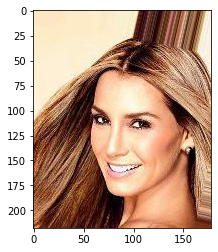

In [9]:
img = Image.open('../../data/celeba/img_align_celeba/000001.jpg')
print(np.asarray(img, dtype=np.uint8).shape)
plt.imshow(img);

In [10]:
class CelebaDataset(Dataset):
    """Custom Dataset for loading CelebA face images"""

    def __init__(self, csv_path, img_dir, transform=None):
    
        df = pd.read_csv(csv_path, index_col=0)
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df.index.values
        self.y = df['Male'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

In [11]:
# Note that transforms.ToTensor()
# already divides pixels by 255. internally
BATCH_SIZE = 256

custom_transform = transforms.Compose([transforms.CenterCrop((178, 178)),
                                       transforms.Resize((128, 128)),
                                       #transforms.Grayscale(),                                       
                                       #transforms.Lambda(lambda x: x/255.),
                                       transforms.ToTensor()])

train_dataset = CelebaDataset(csv_path='celeba-gender-train.csv',
                              img_dir='../../data/celeba/img_align_celeba/',
                              transform=custom_transform)

valid_dataset = CelebaDataset(csv_path='celeba-gender-valid.csv',
                              img_dir='../../data/celeba/img_align_celeba/',
                              transform=custom_transform)

test_dataset = CelebaDataset(csv_path='celeba-gender-test.csv',
                             img_dir='../../data/celeba/img_align_celeba/',
                             transform=custom_transform)


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=4)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=4)

In [12]:
target_model = resnet.ResNet18(2)
target_model.load_state_dict(torch.load("../../out/smile/celeba(f0_m33798)_3e.pth", map_location ='cpu'))
target_model.eval()
print("Model Loaded")

Model Loaded


<h1>SHAP Explain</h1>

In [13]:
target_batch = next(iter(test_loader))
target_images, target_labels = target_batch
target_baseline = target_images
    
target_explain = shap.DeepExplainer(target_model, target_baseline)

In [14]:
r_img = torch.tensor([[[0.0 for col in range(128)] for row in range(128)] for dim in range(3)])
#z_img = z_img.reshape(1,28,28)
r_img.shape
#plt.imshow(z_img.numpy().squeeze())

torch.Size([3, 128, 128])

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


shap_sum 128.06610823818735
shap_sum 83.99368261113767


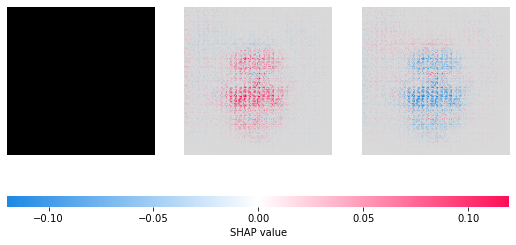

In [15]:
_target_shap_values = shap_plot(target_explain, r_img, 49152)

In [16]:
target_shap_values = torch.tensor(_target_shap_values)
target_shap_values.shape

torch.Size([2, 1, 3, 128, 128])

<h1>MS_FS</h1>

shap_sum 4556.447845192126
shap_sum 4408.516264219597


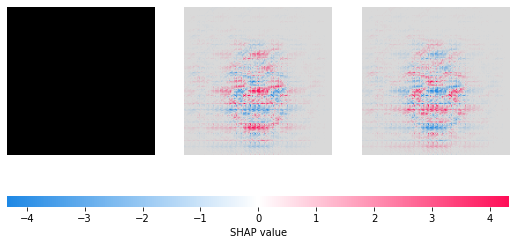

In [26]:
ms_fs_model = resnet.ResNet18(2)
ms_fs_model.load_state_dict(torch.load("../../out/smile/celeba(ms)_5k_3e.pth", map_location ='cpu'))
ms_fs_model.eval()
ms_fs_explain = shap.DeepExplainer(ms_fs_model, target_baseline)
ms_fs_shap_values = shap_plot(ms_fs_explain, r_img, 49152)

<h1>MNS_FNS</h1>

shap_sum 4348.01824903405
shap_sum 5304.668610176823


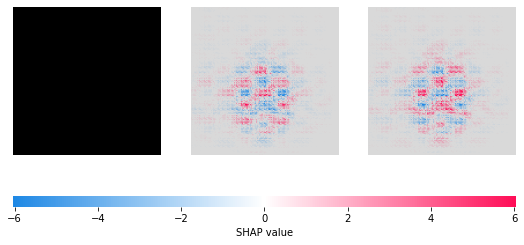

In [27]:
mns_fns_model = resnet.ResNet18(2)
mns_fns_model.load_state_dict(torch.load("../../out/smile/celebas(mns)_5k_3e.pth", map_location ='cpu'))
mns_fns_model.eval()
mns_fns_explain = shap.DeepExplainer(mns_fns_model, target_baseline)
mns_fns_shap_values = shap_plot(mns_fns_explain, r_img, 49152)

<h1>MS_FNS</h1>

shap_sum 4078.160269518845
shap_sum 3569.6413683220044


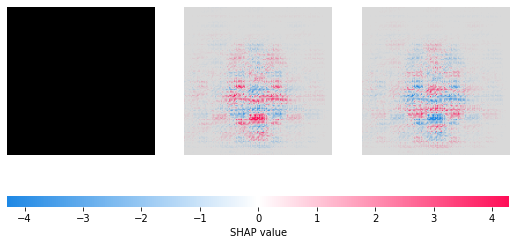

In [28]:
ms_fns_model = resnet.ResNet18(2)
ms_fns_model.load_state_dict(torch.load("../../out/models/celeba(ms_fns)_weights_10k.pth", map_location ='cpu'))
ms_fns_model.eval()
ms_fns_explain = shap.DeepExplainer(ms_fns_model, target_baseline)
ms_fns_shap_values = shap_plot(ms_fns_explain, r_img, 49152)

<h1>MNS_FS</h1>

shap_sum 4877.4755830495005
shap_sum 5946.7948849286895


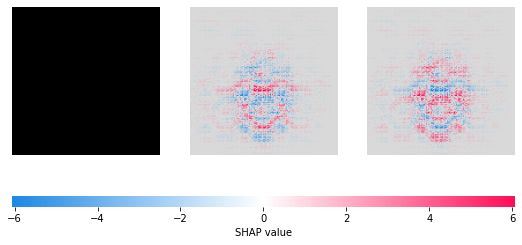

In [29]:
mns_fs_model = resnet.ResNet18(2)
mns_fs_model.load_state_dict(torch.load("../../out/models/celeba(mns_fs)_weights_10k.pth", map_location ='cpu'))
mns_fs_model.eval()
mns_fs_explain = shap.DeepExplainer(mns_fs_model, target_baseline)
mns_fs_shap_values = shap_plot(mns_fs_explain, r_img, 49152)

<h1>Cosine Similarity<h1>

In [30]:
r_shap_female = torch.tensor(target_shap_values[0]).view(-1)
r_shap_male = torch.tensor(target_shap_values[1]).view(-1)

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [31]:
ms_fs_female = torch.tensor(ms_fs_shap_values[0]).view(-1) 
ms_fs_male = torch.tensor(ms_fs_shap_values[1]).view(-1)

In [32]:
mns_fns_female = torch.tensor(mns_fns_shap_values[0]).view(-1) 
mns_fns_male = torch.tensor(mns_fns_shap_values[1]).view(-1) 

In [33]:
ms_fns_female = torch.tensor(ms_fns_shap_values[0]).view(-1) 
ms_fns_male = torch.tensor(ms_fns_shap_values[1]).view(-1) 

In [34]:
mns_fs_female = torch.tensor(mns_fs_shap_values[0]).view(-1) 
mns_fs_male = torch.tensor(mns_fs_shap_values[1]).view(-1) 

In [37]:
print(sim.cosine_similarity(r_shap_female, ms_fs_female))
print(sim.cosine_similarity(r_shap_female, mns_fns_female))
print(sim.cosine_similarity(r_shap_female, ms_fns_female))
print(sim.cosine_similarity(r_shap_female, mns_fs_female))

0.5093158
0.41035816
0.29910254
0.3281865


In [38]:
print(sim.cosine_similarity(r_shap_m
                            
                            ale, ms_fs_male))
print(sim.cosine_similarity(r_shap_male, mns_fns_male))
print(sim.cosine_similarity(r_shap_male, ms_fns_male))
print(sim.cosine_similarity(r_shap_male, mns_fs_male))

0.5106113
0.40624386
0.29950395
0.32682186


shap_sum 112.98685371036657
shap_sum 95.73276945639063


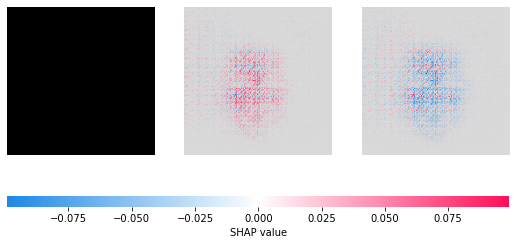

In [33]:
ms_model = resnet.ResNet18(2)
ms_model.load_state_dict(torch.load("../../out/smile/celebas(ms)_10k_3e.pth", map_location ='cpu'))
ms_model.eval()
ms_explain = shap.DeepExplainer(ms_model, target_baseline)
ms_shap_values = shap_plot(ms_explain, r_img, 49152)

shap_sum 112.98685371036657
shap_sum 95.73276945639063


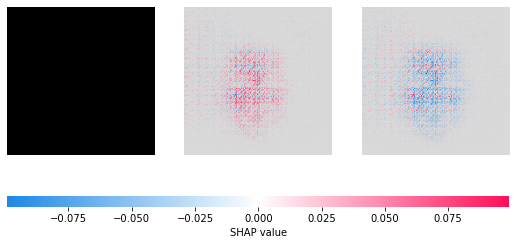

In [34]:
mns_model = resnet.ResNet18(2)
mns_model.load_state_dict(torch.load("../../out/smile/celebas(mns)_10k_3e.pth", map_location ='cpu'))
mns_model.eval()
mns_explain = shap.DeepExplainer(ms_model, target_baseline)
mns_shap_values = shap_plot(ms_explain, r_img, 49152)

In [35]:
r_shap_female = torch.tensor(target_shap_values[0]).view(-1)
r_shap_male = torch.tensor(target_shap_values[1]).view(-1)

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [36]:
ms_female = torch.tensor(ms_shap_values[0]).view(-1) 
ms_male = torch.tensor(ms_shap_values[1]).view(-1)

In [37]:
mns_female = torch.tensor(mns_shap_values[0]).view(-1) 
mns_male = torch.tensor(mns_shap_values[1]).view(-1) 

In [38]:
#print(sim.cosine_similarity(r_shap_female, ms_female))
#print(sim.cosine_similarity(r_shap_female, mns_female))
print(sim.cosine_similarity(r_shap_male, ms_male))
print(sim.cosine_similarity(r_shap_male, mns_male))


0.5378975
0.5378975
